# Sentiment Analysis witn an RNN
In this notebook, you'll implement a recurrent neural network that performs sentiment analysis.

> Using an RNN rather than a strictly feedforward network is more acurate since we can include information about the sequence of words.

Here we'll use a dataset of tweets, accompanied by sentiment labels: positive or negative
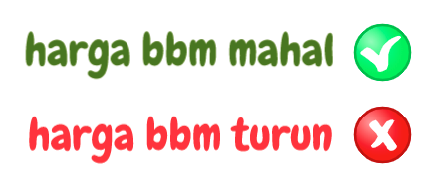

## Network Architecture
The architecture for this network is shown below
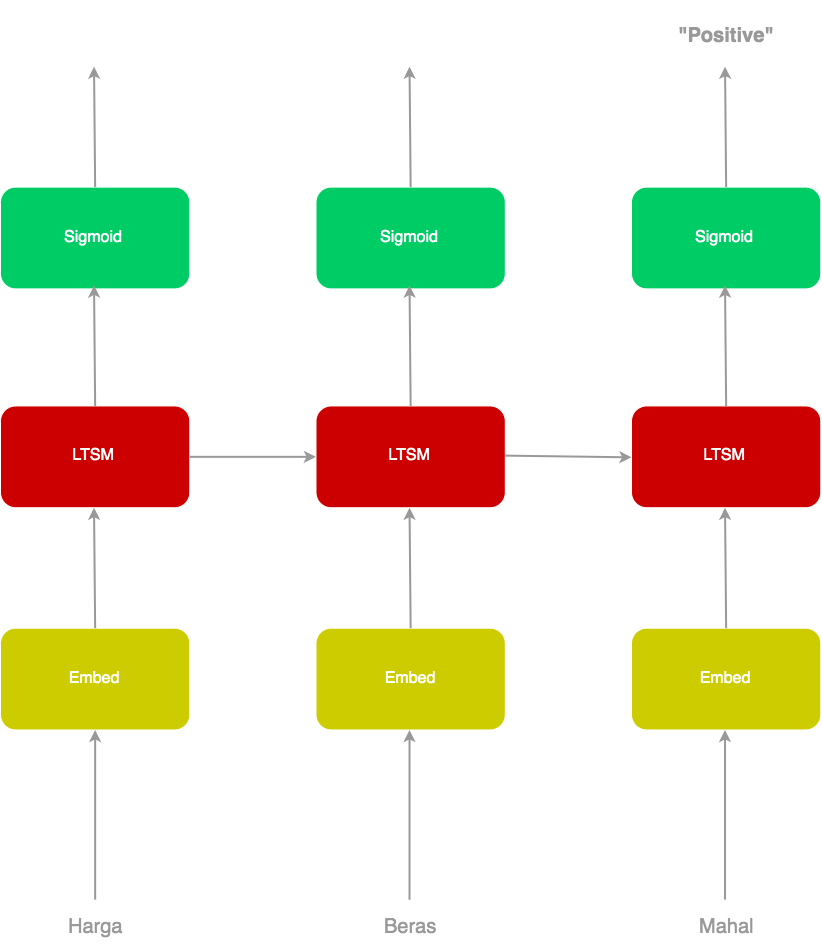
> **First we'll pass in words to an embedding layer.** We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our inout data than one-hot encoded vectors. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. _In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representation._

> **After Input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add _recurrent_ connections to the network and give us the ability to include information about the sequence of words in the tweets data.

> **Finally, the LSTM outputs will go to a sigmoid output layer.** We're using a sigmoid function because positive and negative = 1 and 0, respectively, and sigmoid will output predicted, sentiment values between 0-1

We don't care about sigmoid outputs except for the **very last one** we can ignore the rest. We'll calculate the loss by comparing the output at the last time step and the training label (pos or neg)

## Load in and visualize the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# read data
# TO-DO fill the filename with your file path 
filename = "beras_or_miskin.csv"
df = pd.read_csv(filename, encoding="ISO-8859-1")
df.head()

,hashtags,username,tweet_id,tweet_url,timestamp,text,text_html,links,label
0,[],Des B,1.100000e+18,/descanto/status/1098177427241607168,2/20/19 11:07,Cinta itu adalah jiwa. Antara cinta sejati ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/BuGfDr1FKJn/?utm...,0
1,[],yeni susanti,1.100000e+18,/yenysusanty/status/1097091130422890497,2/17/19 11:11,Selalu salut sama @emakblogersolo yg gak henti...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Bt-xJLygYbh/?utm...,0
2,[],latifah kusuma,1.100000e+18,/latifahkusuma7/status/1095150154439483392,2/12/19 02:38,Ternyata film_okb Mengandung Kisah Nyata Penul...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Btw-fVygrMc/?utm...,0
3,"['_Ù__ä_ç___ç_____µ__µ__Ù', 'yogyakarta...",Imam Munandar,1.090000e+18,/nandar_euy/status/1094458868522934272,2/10/19 04:51,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/BtsEIXsFzI1/?utm...,0
4,"['dolanindie', 'sisijogja', 'infojogja', 'expl...",Mas Titis Waelah,1.090000e+18,/maz_Titiz/status/1094396002167996418,2/10/19 00:41,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...","<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Btrnis6lGF9/?utm...,0


First, we drop the columns that we don't need for specific purpose of sentiment analysis

In [2]:
df.drop(['hashtags', 'username', 'tweet_id', 'tweet_url', 'timestamp', 'text_html','links'], axis =1, inplace=True)

Drop duplicates row

In [20]:
df = pd.DataFrame.drop_duplicates(df)

In [22]:
print(df.shape)
df.head()

(3207, 3)


,text,label,pre_clean_len
0,Cinta itu adalah jiwa. Antara cinta sejati ...,0,285
1,Selalu salut sama @emakblogersolo yg gak henti...,0,284
2,Ternyata film_okb Mengandung Kisah Nyata Penul...,0,282
3,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,0,293
4,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...",0,283


## Data Preparation
As a way of snity check, let's look at the length of the string in the text column in each entry

In [8]:
df['pre_clean_len'] = [len(t) for t in df.text.map(str)]

Plot pre_clean_len with box plot, so that we can see the overall distribution of length of strings in each entry.

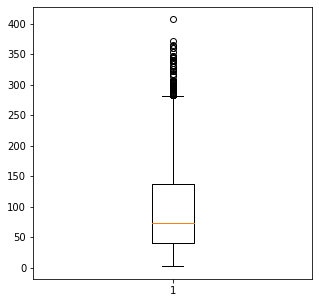

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

From the above box plot, some of tweets are way more than 140 characters long.

In [11]:
df[df.pre_clean_len > 140].head(10)

,text,label,pre_clean_len
0,Cinta itu adalah jiwa. Antara cinta sejati ...,0,285
1,Selalu salut sama @emakblogersolo yg gak henti...,0,284
2,Ternyata film_okb Mengandung Kisah Nyata Penul...,0,282
3,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,0,293
4,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...",0,283
5,Sudahkah Anda memiliki tabungan di Akhirat ?? ...,0,277
6,Cinta itu adalah jiwa. Antara cinta sejati ...,0,285
7,Selalu salut sama @emakblogersolo yg gak henti...,0,284
8,Ternyata film_okb Mengandung Kisah Nyata Penul...,0,282
9,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,0,293


### Cleaning data

dealing with '@'mention
this information doesn't add value to build sentiment analysis model

In [29]:
df.text[1907]

'Gpp kok asal jangan sampe berdebu...\r\rMbak @lrstdw_  mau ikutan dibahagiain pake gombalan orang miskin atau pantun orang kolong jembatan Gak ?'

In [30]:
import re
re.sub(r'@[A-Za-z0-9]+','', df.text[1907])

'Gpp kok asal jangan sampe berdebu...\r\rMbak _  mau ikutan dibahagiain pake gombalan orang miskin atau pantun orang kolong jembatan Gak ?'

Dealing with URL links
same with @mention, for sentiment analysis purpose, this can be ignored

In [31]:
df.text[0]

'\x8a\x97\x93Cinta itu adalah jiwa. Antara cinta sejati dan jiwa tak dapat dipisahkan, cintapun merdeka sebagaimana jiwa. Ia tidak membedakan di antara derajat dan bangsa, di antara kaya dan miskin,\x8a\x97_ https://www.instagram.com/p/BuGfDr1FKJn/?utm_source=ig_twitter_share&igshid=d9qqr424pl5wÎ¾\x8a\x97_'

In [40]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

'\x8a\x97\x93Cinta itu adalah jiwa. Antara cinta sejati dan jiwa tak dapat dipisahkan, cintapun merdeka sebagaimana jiwa. Ia tidak membedakan di antara derajat dan bangsa, di antara kaya dan miskin,\x8a\x97_ ?utm_source=ig_twitter_share&igshid=d9qqr424pl5wÎ¾\x8a\x97_'

Dealing with hashtag / numbers

In [81]:
df.text[485]

'tolong ya kalean semua sadar, bela keluarga kalean dulu. berjuangan buat buat keluarga biar ga ngeluh miskin terus . orang yg kalian bela skrg mungkin lg ena ena dan ketawa. tai #TangkapPRABOWO'

In [86]:
re.sub("[^a-zA-Z]", " ", df.text[485])

'tolong ya kalean semua sadar  bela keluarga kalean dulu  berjuangan buat buat keluarga biar ga ngeluh miskin terus   orang yg kalian bela skrg mungkin lg ena ena dan ketawa  tai  TangkapPRABOWO'

### Defining data cleaning function
With above data cleaning task, we will define data cleaning function and then will be applied to the whole dataset.

In [91]:
from nltk.tokenize import WordPunctTokenizer

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = 'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    letters_only = re.sub("[^a-zA-Z]", " ", stripped)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[50:60]

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

['jauh jauh harga susu bayi harga beras kg aja kayaknya gak ngerti itu orang',
 'dari pengguna twitter instagram facebook menyerukan gerakan menikahlah dan kau akan hidup enak bahagia sentausa yg mana mereka sendiri aja gak tau mumetnya bayar tagihan listrik bayar iuran sampah lingkungan jatah beli beras stok sabun cuci belum lagi dadakan loro',
 'pk tepung beras rosbren ya',
 'ketika diskon lebaran dan isi dompet tidak sehati berasa orang paling miskin dimuka bumi',
 'buka puasa pake beras kencur enak jugak ya',
 'berorganisasi membuatku bertambah miskin',
 'sekarang banyak insan yang resah untuk melangkah di ladang sendiri tidak lain di karenakan premanism juga segolongan yang selalu mementingkan diri sendiri sangat ironis sekali sungguh miskin moral di tanah beribu budaya',
 'sudah mulai kelihatan diskonan hari raya tp maaf ngga tergoda gw gimana mau tergoda sadar miskin duluan gw anj gamampu beli',
 'operasi kelamin pake beras trans gendar',
 'aduh gamau aku pake white pants aku mi

In [97]:
for t in df.text:
    df.loc[(df.text == t), 'text'] = tweet_cleaner(str(t))

### Saving Cleaned data as csv


In [102]:
# TO-DO change the filename
df.drop('pre_clean_len', axis=1).to_csv('clean_beras_or_miskin.csv', encoding='utf-8', index=False)
clean_df = pd.read_csv('clean_beras_or_miskin.csv')
clean_df.head()

,text,label
0,cinta itu adalah jiwa antara cinta sejati dan ...,0
1,selalu salut sama yg gak henti nya memfasilita...,0
2,ternyata film okb mengandung kisah nyata penul...,0
3,boleh miskin asal bahagia asal tau aja caranya...,0
4,janganlah engkau mengarungi lautan percuma deh...,0


## Data pre-processing
The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer.

First, let remove all punctuation. Then get all the text without newlines and split it into individual words

In [116]:
from string import punctuation
all_text = ''.join([c for c in my_df.text.map(str) if c not in punctuation])

#split by new lines and spaces
tweets_split = all_text.split('\n')
all_text = ' '.join(tweets_split)

# create a list of words
words = all_text.split()


In [120]:
print(all_text[:100])
print(len(words))

cinta itu adalah jiwa antara cinta sejati dan jiwa tak dapat dipisahkan cintapun merdeka sebagaimana
44046


### Encoding the words
The embedding lookup requires that we pass in integers to out network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our tweets into integers so they can be passed into the network.

In [126]:
from collections import Counter

#build dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# use the dict to tokenize each tweets in tweets_split
## store the tokenized tweets in tweets_ints
tweets_ints = []
for tweet in tweets_split:
    tweets_ints.append([vocab_to_int[word] for word in tweet.split()])
